<a href="https://colab.research.google.com/github/abhiyantaabhishek/visualization/blob/master/cnn_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [0]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [0]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

In [4]:
model = torchvision.models.squeezenet1_1(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth


In [5]:
!wget http://cs231n.stanford.edu/imagenet_val_25.npz

--2020-04-15 15:52:49--  http://cs231n.stanford.edu/imagenet_val_25.npz
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940548 (3.8M) [text/plain]
Saving to: ‘imagenet_val_25.npz’

imagenet_val_25.npz 100%[===================>]   3.76M  1.97MB/s    in 1.9s    

2020-04-15 15:52:51 (1.97 MB/s) - ‘imagenet_val_25.npz’ saved [3940548/3940548]



In [0]:
def load_imagenet_val(num=None):
    imagenet_fn = 'imagenet_val_25.npz'
    f = np.load(imagenet_fn,allow_pickle=True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

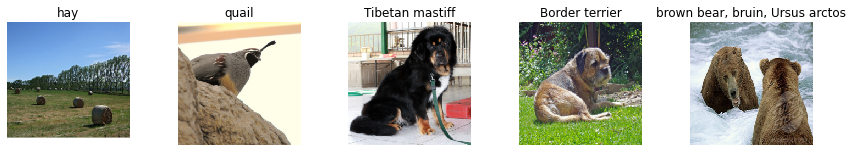

In [7]:
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

#Saliency Maps


In [0]:
def compute_saliency_maps(X, y, model):
    model.eval()
    X.requires_grad_()   
    saliency = None
    scores = model(X)
    scores = (scores.gather(1, y.view(-1, 1)).squeeze())
    grad = np.ones_like(scores.detach().numpy())
    scores.backward(torch.from_numpy(grad))  
    saliency, _ = torch.max(X.grad.data.abs(), dim=1)
    return saliency

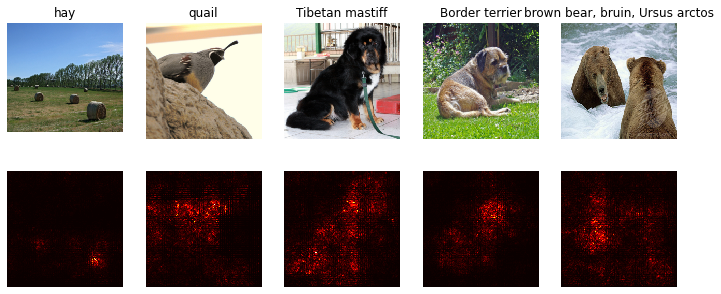

In [9]:
def show_saliency_maps(X, y):
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)


#Adversarial

In [0]:
def make_fooling_image(X, target_y, model):

    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()   
    learning_rate = 1
    for i in range(100):
      scores = model(X_fooling)
      _, pred_y = scores.max(1)
      if(pred_y==target_y):
        print('Done in %d iterations'%(i))
        break
      scores[0,target_y].backward()
      dX = learning_rate*X_fooling.grad.data/torch.norm(X_fooling.grad.data)
      X_fooling.data += dX.data
      X_fooling.grad.data.zero_()
    return X_fooling

In [11]:

idx = 0
target_y = 6

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)


Done in 9 iterations


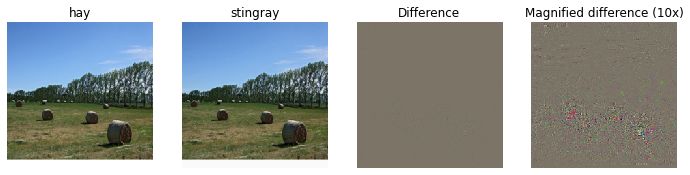

In [12]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()
